# DBR Release Notes
https://docs.databricks.com/en/release-notes/runtime/15.1ml.html

# Optuna
Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

https://pypi.org/project/optuna/

https://optuna.readthedocs.io/en/stable/

# XGBOOST
pip install xgboost

https://xgboost.readthedocs.io/en/stable/

In [0]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# Run Notebook utils

In [0]:
%run  /Workspace/Users/olonok@hotmail.com/utils

# Generate synthetic training data


In [0]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=9000)
df.head()


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,1999-10-13 18:21:02.886953,30.584727,1.371795,0,0,2.147865,1,1099.444263,1149.425524,0.633091,0.018739
1,1999-10-14 18:21:02.886952,15.465069,1.492537,0,1,1.899380,1,1057.550283,1149.425524,1.944332,0.163608
2,1999-10-15 18:21:02.886951,10.786525,3.512421,0,0,1.545055,1,1083.184659,1057.386675,2.237176,0.167797
3,1999-10-16 18:21:02.886950,23.648154,5.812270,1,0,1.882738,1,1391.905781,1083.016862,2.093612,0.379471
4,1999-10-17 18:21:02.886949,13.861391,0.871303,1,0,1.884474,1,1350.428435,1391.526310,0.743679,0.345205


#Examining Feature-Target Correlations


In [0]:
PICS= "/Workspace/Users/olonok@hotmail.com/pics"
correlation_plot = plot_correlation_with_demand(df, save_path=os.path.join(PICS,"correlation_plot.png"))

/root/.ipykernel/1239/command-2546891085146724-3849395620:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()["demand"].drop("demand").sort_values()


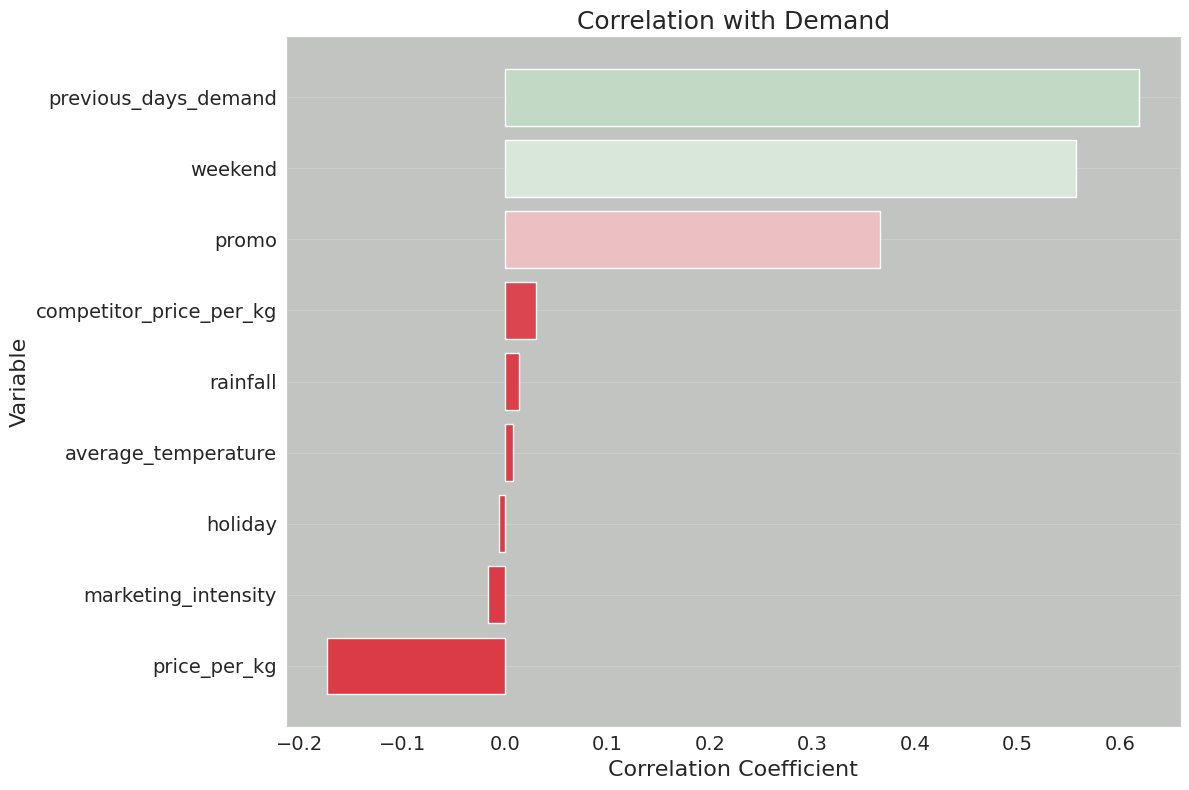

In [0]:
correlation_plot

#Create an experiment for our hyperparameter tuning runs

In [0]:
experiment_id = get_or_create_experiment("/Users/olonok@hotmail.com/Apples Demand")
experiment_id

'2546891085146744'

# Setting Up MLflow and Data Preprocessing for Model Training

In [0]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

In [0]:
params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
        }

bst = xgb.train( params, dtrain)
preds = bst.predict(dvalid)
error = mean_squared_error(valid_y, preds)

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
error, math.sqrt(error)

(30181.57286309513, 173.72844575110642)

# Hyperparameter Tuning and Model Training using Optuna and MLflow

In [0]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")



def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error


# Orchestrating Hyperparameter Tuning, Model Training, and Logging with MLflow


In [0]:
import datetime
now  = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
now

'2024-06-02_17:03:01'

In [0]:
import datetime
now  = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

run_name = f"apple_demand_{now}"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True) as run:
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=200, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 2},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


Initial trial 0 achieved value: 51642.022471126176
Trial 10 achieved value: 51154.17129647954 with  0.9537% improvement
Trial 29 achieved value: 34269.3589636536 with  49.2709% improvement
Trial 32 achieved value: 34233.37723540966 with  0.1051% improvement
Trial 33 achieved value: 34029.95259470175 with  0.5978% improvement
Trial 34 achieved value: 33968.07229228862 with  0.1822% improvement
Trial 38 achieved value: 33914.4893418756 with  0.1580% improvement
Trial 55 achieved value: 32042.645491010648 with  5.8417% improvement
Trial 57 achieved value: 31934.263311773193 with  0.3394% improvement
Trial 62 achieved value: 31824.232736997135 with  0.3457% improvement
Trial 67 achieved value: 31727.766530293637 with  0.3040% improvement
Trial 104 achieved value: 31549.194107286836 with  0.5660% improvement
Trial 105 achieved value: 31265.49710554083 with  0.9074% improvement


/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/6 [00:00<?, ?it/s]

# Inference

In [0]:
run.to_dictionary()

{'info': {'artifact_uri': 'dbfs:/databricks/mlflow-tracking/2546891085146744/968f7b3399c843e890f18f212a20d302/artifacts',
  'end_time': None,
  'experiment_id': '2546891085146744',
  'lifecycle_stage': 'active',
  'run_id': '968f7b3399c843e890f18f212a20d302',
  'run_name': 'apple_demand_2024-06-02_18:35:24',
  'run_uuid': '968f7b3399c843e890f18f212a20d302',
  'start_time': 1717353325356,
  'status': 'RUNNING',
  'user_id': ''},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.databricks.cluster.id': '0531-123607-lblvj6fa',
   'mlflow.databricks.notebook.commandID': '1473973421898776429_7989566754412881815_ed36f6d002c44bb6aaea28421e8a4aa4',
   'mlflow.databricks.notebookID': '2546891085146716',
   'mlflow.databricks.notebookPath': '/Users/olonok@hotmail.com/MLflow with Optuna: Hyperparameter Optimization and Tracking',
   'mlflow.databricks.webappURL': 'https://ukwest.azuredatabricks.net',
   'mlflow.databricks.workspaceID': '1286930193882465',
   'mlflow.databricks.workspace

In [0]:
loaded = mlflow.xgboost.load_model(model_uri)

In [0]:
batch_dmatrix = xgb.DMatrix(X)

inference = loaded.predict(batch_dmatrix)

infer_df = df.copy()

infer_df["predicted_demand"] = inference

In [0]:
infer_df


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity,predicted_demand
0,1999-10-13 18:21:02.886953,30.584727,1.371795,0,0,2.147865,1,1099.444263,1149.425524,0.633091,0.018739,1224.108032
1,1999-10-14 18:21:02.886952,15.465069,1.492537,0,1,1.899380,1,1057.550283,1149.425524,1.944332,0.163608,1247.616089
2,1999-10-15 18:21:02.886951,10.786525,3.512421,0,0,1.545055,1,1083.184659,1057.386675,2.237176,0.167797,1301.664185
3,1999-10-16 18:21:02.886950,23.648154,5.812270,1,0,1.882738,1,1391.905781,1083.016862,2.093612,0.379471,1556.916748
4,1999-10-17 18:21:02.886949,13.861391,0.871303,1,0,1.884474,1,1350.428435,1391.526310,0.743679,0.345205,1752.701538
...,...,...,...,...,...,...,...,...,...,...,...,...
8995,2024-05-29 18:21:02.877059,16.899091,1.670177,0,0,1.128328,0,1678.660474,1469.823905,1.639185,0.844783,1374.028442
8996,2024-05-30 18:21:02.877058,24.564961,9.135192,0,0,2.252181,0,1546.290062,1677.815691,1.796946,0.844783,1294.347168
8997,2024-05-31 18:21:02.877057,14.148144,3.176544,0,0,1.537770,0,1674.019109,1595.445279,2.876909,0.998988,1412.086426
8998,2024-06-01 18:21:02.877055,11.882510,0.190450,1,0,2.053251,0,2000.675816,1673.020121,0.666657,0.946617,1698.282104
